In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, Add
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 as cv
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
BATCH_SIZE = 8
IMAGE_SIZE = (244, 244)
CHANNELS = 3
EPOCHS = 20

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset
dataset_path = '/content/drive/MyDrive/Plant_Directory/Dataset'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 3806 files belonging to 2 classes.


In [5]:
# Get class names
class_names = dataset.class_names
print('Class names:', class_names)

Class names: ['peach_bacterial', 'peach_healthy']


In [6]:
# Preprocess data
im_size = 244
images = []
labels = []
for i in class_names:
  data_path = os.path.join(dataset_path, i)
  filenames = os.listdir(data_path)

  for j, f in enumerate(filenames):
    if j == 800:
      break
    img = cv.imread(os.path.join(data_path, f))
    img = cv.resize(img, (im_size, im_size))
    images.append(img)
    labels.append(i)
images = np.array(images)
images = images.astype('float32') / 255.0


In [7]:
# Encode labels
y = np.array(labels)
y_labelencoder = LabelEncoder()
y = y_labelencoder.fit_transform(y)
y = y.reshape(-1, 1)
onehotencoder = OneHotEncoder(categories='auto')
Y = onehotencoder.fit_transform(y).toarray()

In [8]:
# Shuffle and split data
images, Y = shuffle(images, Y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.2, random_state=200)

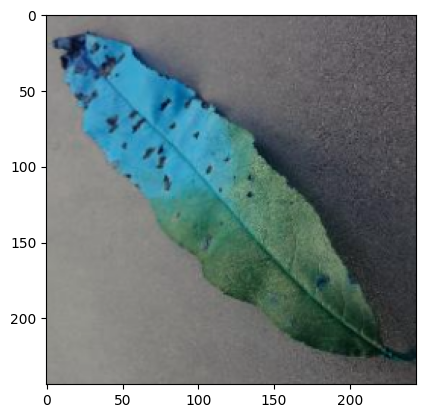

In [9]:
# to print images
plt.imshow(images[0])

In [10]:
# Define residual block function
def residual_block(x, filters, kernel_size=3, strides=1, padding='same'):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [11]:
from keras.layers import Input

In [12]:
#define resnet model
def ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, strides=2)
    x = residual_block(x, 512)
    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    return model
    print(model.input_shape)


In [13]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(input_shape=(im_size, im_size, 3), weights=None, classes=len(class_names))

In [14]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 250, 250, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 122, 122, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [16]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
lr=ReduceLROnPlateau(monitor='val_loss',factor=0.003,verbose=1,patience=3)
earlyst=EarlyStopping(monitor="val_loss",verbose=1,mode="min",patience=10,restore_best_weights=True)
cb=[lr]

In [17]:
# Train model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=cb)

Epoch 1/20
160/160 [==============================] - 73s 139ms/step - loss: 0.5099 - accuracy: 0.8711 - val_loss: 0.8699 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 2/20
160/160 [==============================] - 19s 120ms/step - loss: 0.1896 - accuracy: 0.9406 - val_loss: 1.2216 - val_accuracy: 0.6781 - lr: 0.0010
Epoch 3/20
160/160 [==============================] - 19s 122ms/step - loss: 0.2438 - accuracy: 0.9367 - val_loss: 2.5180 - val_accuracy: 0.5781 - lr: 0.0010
Epoch 4/20
160/160 [==============================] - 20s 123ms/step - loss: 0.2436 - accuracy: 0.9141 - val_loss: 0.6264 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 5/20
160/160 [==============================] - 21s 131ms/step - loss: 0.1447 - accuracy: 0.9461 - val_loss: 0.5074 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 6/20
160/160 [==============================] - 20s 124ms/step - loss: 0.2203 - accuracy: 0.9195 - val_loss: 5.0124 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 7/20
160/160 [==============================] 

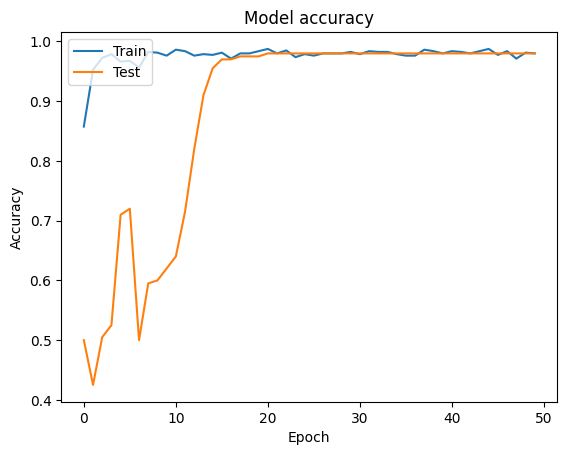

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/ResNet-50Final")

In [ ]:
preds=model.evaluate(test_x,test_y)
print("loss="+ str(preds[0]))

7/7 [==============================] - 4s 207ms/step - loss: 0.0823 - accuracy: 0.9800
loss=0.08228124678134918


In [ ]:
import keras
model=keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ResNet-50Final")

In [ ]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
import cv2 as cv
import numpy as np

input image shape: (1, 244, 244, 3)


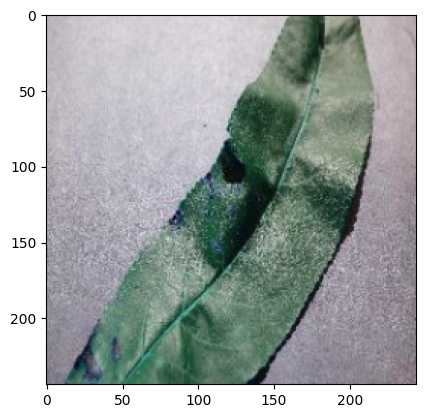

In [ ]:
img_path='/content/drive/MyDrive/Plant_Directory/Dataset/peach_bacterial/00130039-8425-42e9-9dd9-15aead7271ff___Rut._Bact.S 3421.JPG'
img=cv.resize(cv.imread(img_path),(244,244))
x=np.expand_dims(img,axis=0)
print('input image shape:',x.shape)
imshow(img)

In [ ]:
result=model.predict(x)

1/1 [==============================] - 0s 25ms/step


In [ ]:
if(result[0][0]<result[0][1]):
  print(f"Peach leaf is a Bacterial Spot Peach Leaf with {result[0][1]}% assurity")
else:
  print(f"Peach leaf is a Healthy Peach Leaf with {result[0][0]}% assurity")

Peach leaf is a Bacterial Spot Peach Leaf with 1.0% assurity
